In [30]:
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from juligrad import ops, tensor, optim, nn
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create half moon dataset

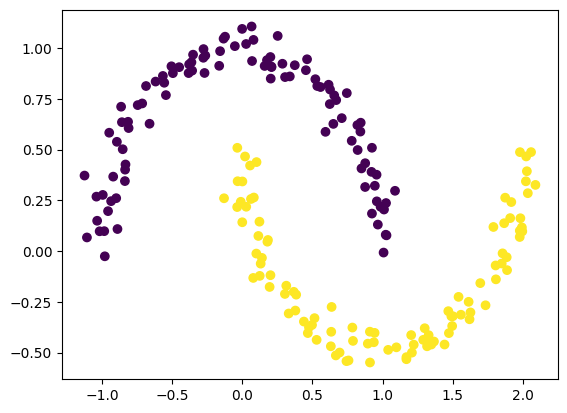

In [31]:
X, y = make_moons(n_samples=200, noise=0.06)
X, y = tensor.Tensor.fromNumpy(X, requiresGrad = False), tensor.Tensor.fromNumpy(y[:,None], requiresGrad=False)
plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=y.numpy())

## Logistic regression

Accuracy: 0.875


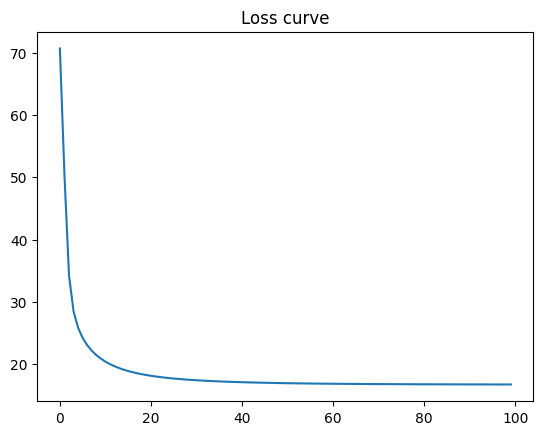

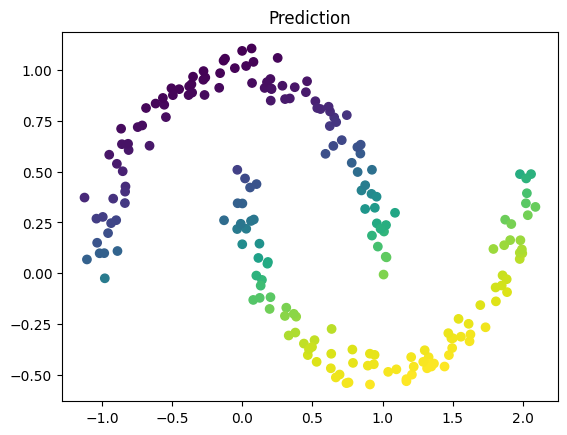

In [32]:
W = tensor.Tensor.uniform(size = (2,1))
b = tensor.Tensor.uniform(size = (1,1))
optimizer = optim.SGD(params=[W,b], lr=1e-2)
nEpoch = 100
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = (X @ W + b.expand(repeats = X.shape[0], dim=0)).sigmoid()
    loss = ((y-pred)**2).sum()
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = (X @ W + b.expand(repeats = X.shape[0], dim=0)).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');

Accuracy: 0.875


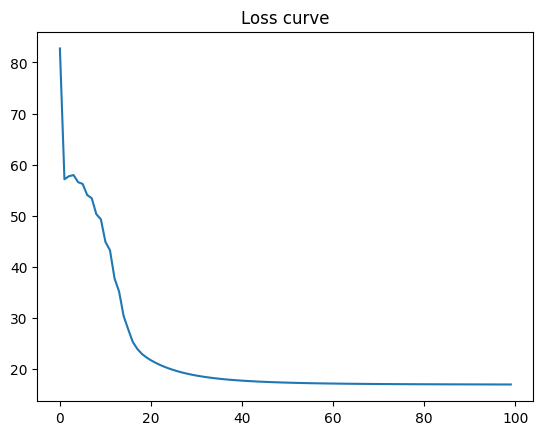

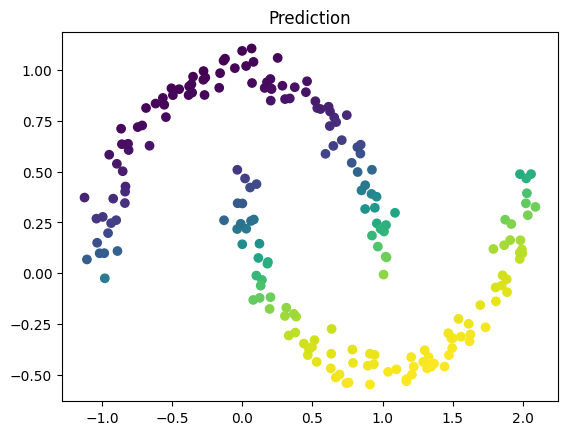

In [33]:
W1 = tensor.Tensor.uniform(size = (2,5))
b1 = tensor.Tensor.uniform(size = (1,5))
W2 = tensor.Tensor.uniform(size = (5,1))
b2= tensor.Tensor.uniform(size = (1,1))

optimizer = optim.SGD(params=[W1,b1, W2, b2], lr=1e-2)
nEpoch = 100
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    hidden = (X @ W1 + b1.expand(repeats = X.shape[0], dim=0)).sigmoid()
    pred = (hidden @ W2 + b2.expand(repeats = hidden.shape[0], dim=0)).sigmoid()
    loss = ((y-pred)**2).sum()
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

hidden = (X @ W1 + b1.expand(repeats = X.shape[0], dim=0)).sigmoid()
pred = (hidden @ W2 + b2.expand(repeats = hidden.shape[0], dim=0)).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');

## Using nn modules

[[-0.30483685]
 [-0.37924848]
 [-0.29650969]
 [-0.49881671]
 [-0.31178038]
 [-0.40661799]
 [-0.14059705]
 [-0.86446768]
 [-0.2861811 ]
 [-0.30414578]
 [-0.19083547]
 [-0.24083668]
 [-0.53948105]
 [-0.56505209]
 [-0.98531428]
 [-0.32222121]
 [-0.46720186]
 [-0.63067116]
 [-0.2779298 ]
 [-0.67069151]
 [-0.36115391]
 [-1.18141577]
 [-0.215016  ]
 [-0.74418694]
 [-0.09349646]
 [-0.53342422]
 [-0.18287104]
 [-0.46401901]
 [-0.16079236]
 [-0.2855696 ]
 [-0.7375853 ]
 [-0.67481501]
 [-0.30388131]
 [-0.14327672]
 [-0.10004485]
 [-0.34288276]
 [-0.16026025]
 [-0.61033283]
 [-0.2957456 ]
 [-0.45915254]
 [-0.6440585 ]
 [-0.2963019 ]
 [-0.7332625 ]
 [-0.10967464]
 [-0.47622082]
 [-0.4038914 ]
 [-0.28816044]
 [-0.13141994]
 [-0.12837264]
 [-0.59333692]
 [-0.17987705]
 [-0.35378591]
 [-1.36590585]
 [-0.5204567 ]
 [-0.20627752]
 [-0.11040038]
 [-0.78683863]
 [-1.15383755]
 [-0.25158984]
 [-0.57544867]
 [-0.31131783]
 [-1.34951123]
 [-0.51070864]
 [-0.94971573]
 [-0.52973937]
 [-0.20421581]
 [-0.09169

/Users/julianvanmeggelen/Documents/juligrad eager/juligrad/ops.py:122: RuntimeWarning: divide by zero encountered in log
  return Tensor(data=np.log(a.data),  sourceOp=self)
/Users/julianvanmeggelen/Documents/juligrad eager/juligrad/ops.py:125: RuntimeWarning: divide by zero encountered in divide
  self.a.backward(Tensor(data=grad_out.data/self.a.data, requiresGrad=False))
/Users/julianvanmeggelen/Documents/juligrad eager/juligrad/ops.py:100: RuntimeWarning: invalid value encountered in multiply
  self.a.backward(Tensor(data=grad_out.data * self.sigx * (1-self.sigx), shape=grad_out.shape, requiresGrad=False))


[[-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 [-100.]
 

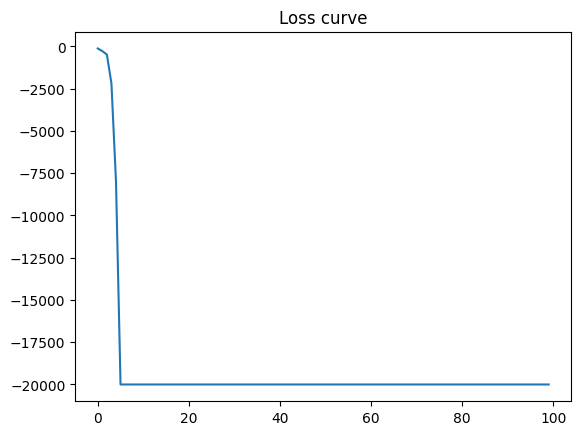

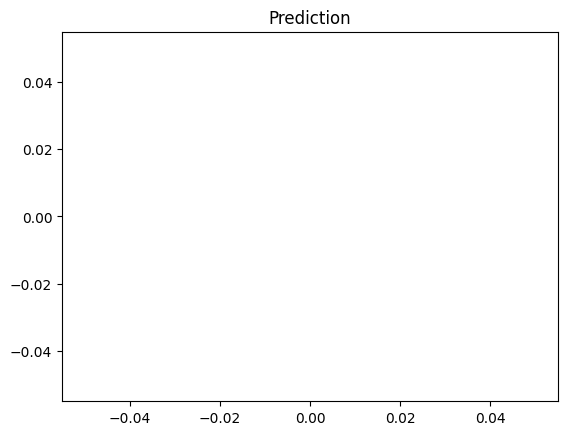

In [49]:
def BCELoss(pred, y):   
    ones = tensor.Tensor.fromNumpy(np.full(shape = pred.shape, fill_value=1.0), requiresGrad = False)
    eps = tensor.Tensor.fromNumpy(np.full(shape = pred.shape, fill_value=1e-3), requiresGrad = False)
    a = (pred + eps).log()
    a.data = np.where(np.isnan(a.data), -100, np.clip(a.data, -100, np.inf))
    b = (ones-pred+eps).log()
    b.data = np.where(np.isnan(b.data), -100, np.clip(b.data, -100, np.inf))
    print(a,b)
    return (y * a + (ones-y) * b).sum()

linear = nn.Linear(shapeIn=2, shapeOut=1)
optimizer = optim.SGD(params=linear.parameters(), lr=1e-2)
nEpoch = 100
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = linear(X).sigmoid()
    #loss = ((y-pred)**2).sum()
    loss = BCELoss(pred, y)
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = linear(X).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');

Accuracy: 0.5


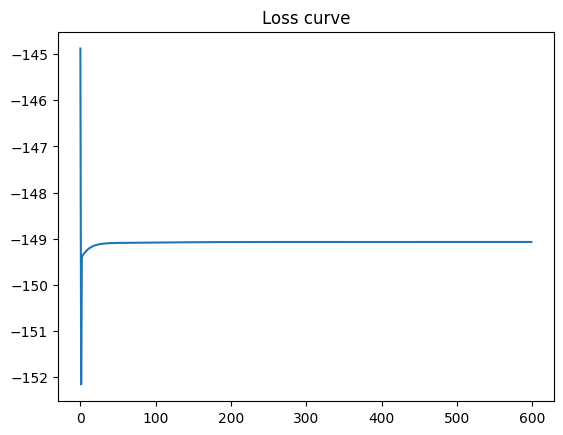

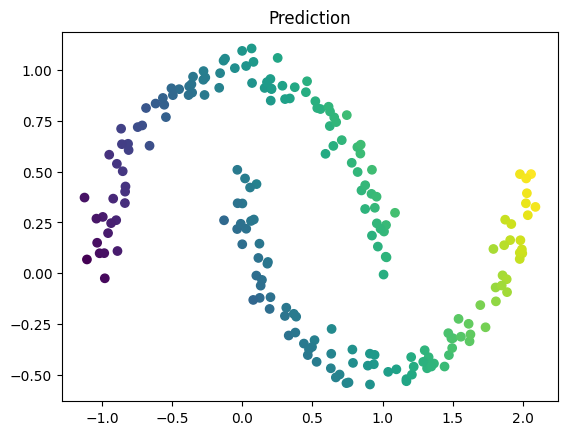

In [39]:
def BCELoss(pred, y):
   ones = tensor.Tensor.fromNumpy(np.full(shape = pred.shape, fill_value=1.0))
   return (y * pred.log() + (ones-y) * (ones-pred).log()).sum()

mlp = nn.MLP(hiddenDim = [2,10,1], activations = ops.Sigmoid)
optimizer = optim.SGD(params=mlp.parameters(), lr=2e-2)
nEpoch = 600
lossHist = []
for i in range(nEpoch):
    optimizer.zeroGrad()
    pred = mlp(X).sigmoid()
    #loss = ((y-pred)**2).sum()
    loss = BCELoss(pred,y)
    lossHist.append(loss.numpy())
    loss.backward()
    optimizer.step()

plt.plot(lossHist);plt.title('Loss curve');

pred = mlp(X).sigmoid()
acc = (pred.data.round() == y.data).sum()/y.shape[0]

print(f"Accuracy: {acc}")
plt.figure(); plt.scatter(x=X.numpy()[:,0], y=X.numpy()[:,1], c=pred.data); plt.title('Prediction');